In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
import jax.numpy as jnp
from matplotlib import colors
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set_theme()
sns.set_theme(style="white")

import numpy as np
import pickle
from sklearn.model_selection import train_test_split
load_path = os.path.join('OriginalData', 'dataset.pkl')
    # load dataset
with open(load_path, 'rb') as f:
    loaded_dataset = pickle.load(f)



In [ ]:

import matplotlib.colors as mcolors

def plot_quiver(ax, x, y, zorder=1):
    ax.quiver(
    x[:-1], y[:-1],     
    x[1:] - x[:-1], y[1:]-y[:-1],     
    angles='xy',   
    scale_units='xy',
    scale=1.05,
    width=0.008, 
    headwidth=4,
    headlength=6,
    zorder=zorder,
    color='green',
)

def PlotV(net, config, level_end =500.0, Title = None, x_test_np=None, ep_min=10, ep_max=200, traj_len=1750, num=0, steps=200, Z_domain=None):

    if Z_domain is None:
        z1_min, z1_max = -2.8,0.2
        z2_min, z2_max = -1.7, 1.7
        z3_min, z3_max = -3.5, 3.5
    else:
        z1_min, z1_max = Z_domain[0,0], Z_domain[0,1]
        z2_min, z2_max = Z_domain[1,0], Z_domain[1,1]
        z3_min, z3_max = Z_domain[2,0], Z_domain[2,1]

    num_samples_aux_dimension = 128
    def V(z1, z2, z3):
        z = jnp.array([z1, z2, z3])
        return net.potential(z, [config.temperature])

    def EPR(z):
        temperature = config.temperature 
        dvdx = jax.grad(net.potential, argnums=0)(z, [temperature])

        #compution of the gamma term
        H = net.Hamiltonian(z)
        grad_H = jax.jacfwd(net.Hamiltonian, argnums=0)(z)
        gamma = temperature * jnp.einsum('dab,db->a', net.J, grad_H) - jnp.einsum('d,dab,b->a', H, net.J, dvdx)
        
        dissipation = net.dissipation(z)
        return gamma @(jnp.linalg.inv(dissipation)@gamma)


    @jax.vmap
    @jax.jit
    def V_12(z1, z2):
        z3_test_range = jnp.linspace(z3_min, z3_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (None, None, 0))(z1, z2, z3_test_range))

    @jax.vmap
    @jax.jit
    def V_13(z1, z3):
        z2_test_range = jnp.linspace(z2_min, z2_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (None, 0, None))(z1, z2_test_range, z3))

    @jax.vmap
    @jax.jit
    def V_23(z2, z3):
        z1_test_range = jnp.linspace(z1_min, z1_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (0, None, None))(z1_test_range, z2, z3))
    num_grid = 100
    num_levels = 21
    off_set = 0
    level_start = 0.0
    
    f_x = jax.vmap(EPR)(x_test_np)
    norm = mcolors.LogNorm(vmin=ep_min, vmax=ep_max)

    custom_levels = jnp.linspace(level_start, level_end, num_levels) 
    # Define the range and number of points in each dimension
    z1_range = jnp.linspace(z1_min - off_set, z1_max + off_set, num_grid)
    z2_range = jnp.linspace(z2_min - off_set, z2_max + off_set, num_grid)
    z3_range = jnp.linspace(z3_min - off_set, z3_max + off_set, num_grid)

    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1,
                    wspace=0.2,
                    hspace=0.0) 

    # V12
    Z1, Z2 = jnp.meshgrid(z1_range, z2_range)
    V12_grid =  V_12(Z1.ravel(), Z2.ravel()).reshape(Z1.shape)
    V12_0 = jnp.min(V12_grid) 
    contour1 = ax[0].contourf(Z1, Z2, V12_grid-V12_0, levels=custom_levels, cmap='Greys_r', zorder=1)
    ep1 = ax[0].scatter(x_test_np[:, 0], x_test_np[:, 1], s=0.01, c=f_x, cmap='plasma', norm=norm, zorder=2)
 
    # ax[0].set_title(r'$V_{12}$')
    ax[0].set_xlabel(r'$Z_1$')
    ax[0].set_ylabel(r'$Z_2$')

    # V13
    Z1, Z3 = jnp.meshgrid(z1_range, z3_range)
    V13_grid = V_13(Z1.ravel(), Z3.ravel()).reshape(Z1.shape)
    V13_0 = jnp.min(V13_grid) 
    contour2 = ax[1].contourf(Z1, Z3, V13_grid-V13_0, levels=custom_levels, cmap='Greys_r', zorder=1)
    ep2 = ax[1].scatter(x_test_np[:, 0], x_test_np[:, 2], s=0.01, c=f_x, cmap='plasma', norm=norm, zorder=2)

    traj_ep2=ax[1].scatter(x_test_np[num*traj_len:(num+1)*traj_len:steps, 0], x_test_np[num*traj_len:(num+1)*traj_len:steps, 2], 
                           c=f_x[num*traj_len:(num+1)*traj_len:steps], cmap='plasma', alpha=1, edgecolor='black', linewidth=1, norm=norm, zorder=4) 
    plot_quiver(ax[1], x_test_np[num*traj_len:(num+1)*traj_len:steps, 0], x_test_np[num*traj_len:(num+1)*traj_len:steps, 2], zorder=3)

    # ax[1].set_title(r'$V_{13}$')
    ax[1].set_xlabel(r'$Z_1$')
    ax[1].set_ylabel(r'$Z_3$')

    # V23
    Z2, Z3 = jnp.meshgrid(z2_range, z3_range)
    V23_grid = V_23(Z2.ravel(), Z3.ravel()).reshape(Z1.shape)
    V23_0 = jnp.min(V23_grid) 
    contour3 = ax[2].contourf(Z2, Z3, V23_grid - V23_0, levels=custom_levels, cmap='Greys_r', zorder=1)
    ep3 = ax[2].scatter(x_test_np[:, 1], x_test_np[:, 2], s=0.01, c=f_x, cmap='plasma', norm=norm, zorder=2)
    # traj_ep3=ax[2].scatter(x_test_np[1*1751:2*1751:200, 1], x_test_np[1*1751:2*1751:200, 2], 
    #                        c=f_x[1*1751:2*1751:200], cmap='plasma', alpha=1, linewidth=1, norm=norm, zorder=4) 
    # plot_quiver(ax[2], x_test_np[1*1751:2*1751:200, 1], x_test_np[1*1751:2*1751:200, 2], zorder=3)
    # ax[2].set_title(r'$V_{23}$')



    ax[2].set_xlabel(r'$Z_2$')
    ax[2].set_ylabel(r'$Z_3$')
    cbar  = fig.colorbar(contour3, ax=ax, orientation='vertical', fraction=0.02, pad=0.02, label=r'Potential $V$')
    cbar2 = fig.colorbar(ep1, ax=ax, orientation='vertical', fraction=0.02, pad=0.07, location='left', label=r'Total EPR $\dot{s}_{{tot}}$')
    if Title is not None:
        fig.suptitle(Title)
    return f_x, fig, ax, V12_grid - V12_0, V13_grid - V13_0, V23_grid - V23_0

Processing dataset: F1_62_T1
Processing dataset: F2_31_T1
Processing dataset: F2_78_T1
Processing dataset: F3_93_T1
Processing dataset: F4_63_T1
Processing dataset: F11_60_T1
Processing dataset: F16_20_T1
Processing dataset: F23_10_T1


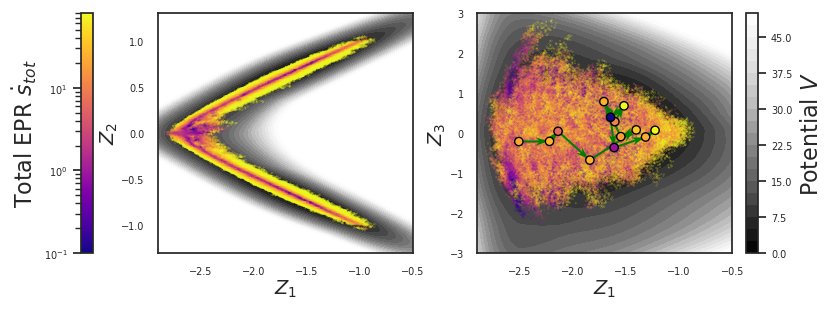

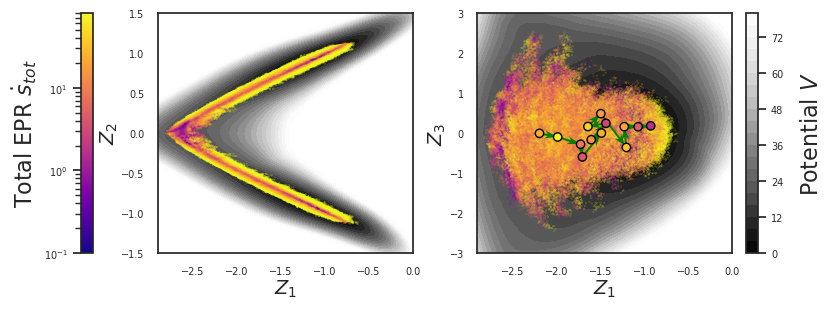

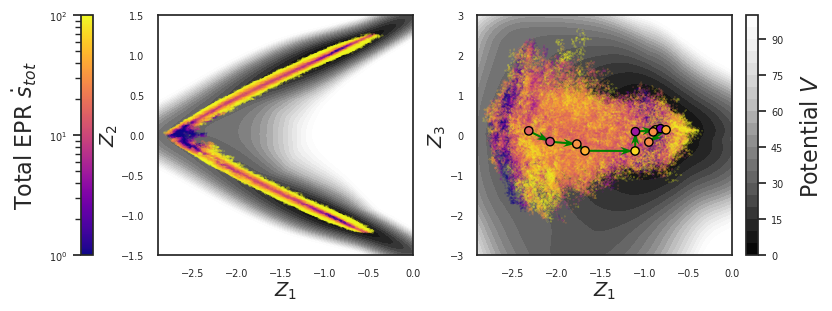

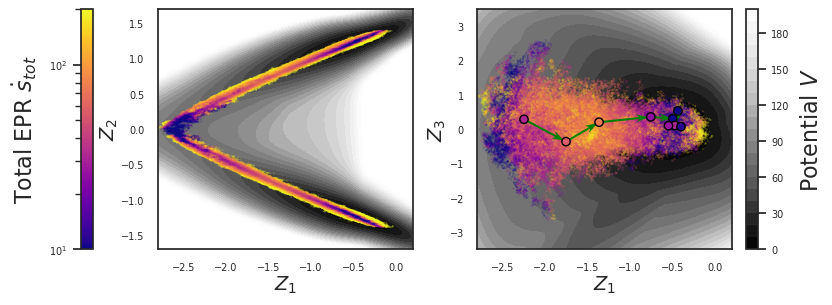

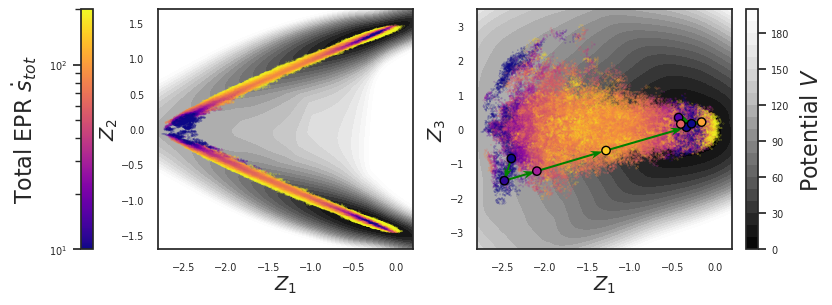

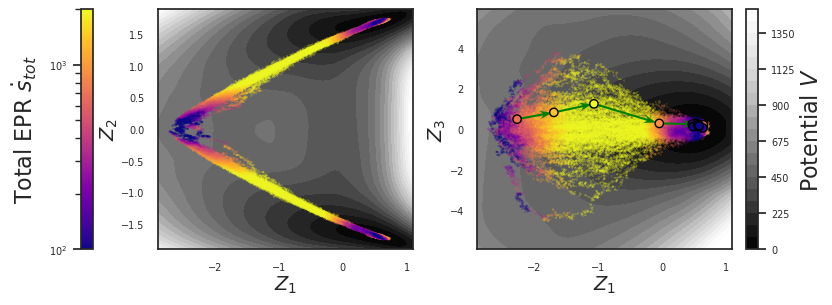

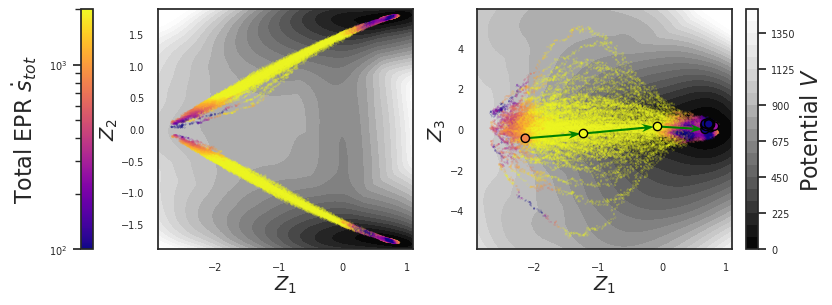

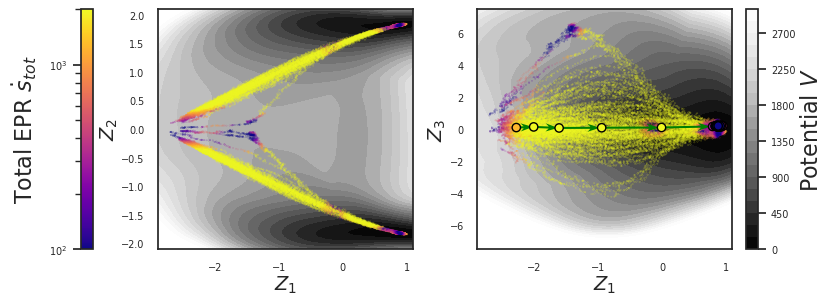

In [ ]:
from matplotlib.ticker import FormatStrFormatter
def PlotV2(net, config, level_end =500.0, Title = None, x_test_np=None, ep_min=10, ep_max=200, traj_len=1750, num=0, steps=200, Z_domain=None):

    if Z_domain is None:
        z1_min, z1_max = -2.8,0.2
        z2_min, z2_max = -1.7, 1.7
        z3_min, z3_max = -3.5, 3.5
    else:
        z1_min, z1_max = Z_domain[0,0], Z_domain[0,1]
        z2_min, z2_max = Z_domain[1,0], Z_domain[1,1]
        z3_min, z3_max = Z_domain[2,0], Z_domain[2,1]

    num_samples_aux_dimension = 128
    def V(z1, z2, z3):
        z = jnp.array([z1, z2, z3])
        return net.potential(z, [config.temperature])

    def EPR(z):
        temperature = config.temperature 
        dvdx = jax.grad(net.potential, argnums=0)(z, [temperature])

        #compution of the gamma term
        H = net.Hamiltonian(z)
        grad_H = jax.jacfwd(net.Hamiltonian, argnums=0)(z)
        gamma = temperature * jnp.einsum('dab,db->a', net.J, grad_H) - jnp.einsum('d,dab,b->a', H, net.J, dvdx)
        
        dissipation = net.dissipation(z)
        return gamma @(jnp.linalg.inv(dissipation)@gamma)


    @jax.vmap
    @jax.jit
    def V_12(z1, z2):
        z3_test_range = jnp.linspace(z3_min, z3_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (None, None, 0))(z1, z2, z3_test_range))

    @jax.vmap
    @jax.jit
    def V_13(z1, z3):
        z2_test_range = jnp.linspace(z2_min, z2_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (None, 0, None))(z1, z2_test_range, z3))

    @jax.vmap
    @jax.jit
    def V_23(z2, z3):
        z1_test_range = jnp.linspace(z1_min, z1_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (0, None, None))(z1_test_range, z2, z3))
    num_grid = 100
    num_levels = 21
    off_set = 0
    level_start = 0.0
    
    f_x = jax.vmap(EPR)(x_test_np)
    norm = mcolors.LogNorm(vmin=ep_min, vmax=ep_max)

    custom_levels = jnp.linspace(level_start, level_end, num_levels) 
    # Define the range and number of points in each dimension
    z1_range = jnp.linspace(z1_min - off_set, z1_max + off_set, num_grid)
    z2_range = jnp.linspace(z2_min - off_set, z2_max + off_set, num_grid)
    z3_range = jnp.linspace(z3_min - off_set, z3_max + off_set, num_grid)

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1,
                    wspace=0.25,    # 水平方向间距（子图宽度的 0.4 倍）
                    hspace=0.0) 

    # V12
    Z1, Z2 = jnp.meshgrid(z1_range, z2_range)
    V12_grid =  V_12(Z1.ravel(), Z2.ravel()).reshape(Z1.shape)
    V12_0 = jnp.min(V12_grid) 
    contour1 = ax[0].contourf(Z1, Z2, V12_grid-V12_0, levels=custom_levels, cmap='Greys_r', zorder=1)
    ep1 = ax[0].scatter(x_test_np[:, 0], x_test_np[:, 1], s=0.01, c=f_x, cmap='plasma', norm=norm, zorder=2)
    for coll in contour1.collections:
        coll.set_rasterized(True)
    ep1.set_rasterized(True)
 
 
    # ax[0].set_title(r'$V_{12}$') 
    ax[0].set_xlabel(r'$Z_1$', fontsize=14, labelpad=1)  # labelpad 越小越贴近
    ax[0].set_ylabel(r'$Z_2$', fontsize=14, labelpad=1)

    # 调整刻度字体大小
    ax[0].tick_params(axis='both', which='major', labelsize=7) 


    # V13
    Z1, Z3 = jnp.meshgrid(z1_range, z3_range)
    V13_grid = V_13(Z1.ravel(), Z3.ravel()).reshape(Z1.shape)
    V13_0 = jnp.min(V13_grid) 
    contour2 = ax[1].contourf(Z1, Z3, V13_grid-V13_0, levels=custom_levels, cmap='Greys_r', zorder=1)
    ep2 = ax[1].scatter(x_test_np[:, 0], x_test_np[:, 2], s=0.01, c=f_x, cmap='plasma', norm=norm, zorder=2)
    for coll in contour2.collections:
        coll.set_rasterized(True)
    ep2.set_rasterized(True)


    traj_ep2=ax[1].scatter(x_test_np[num*traj_len:(num+1)*traj_len:steps, 0], x_test_np[num*traj_len:(num+1)*traj_len:steps, 2], 
                           c=f_x[num*traj_len:(num+1)*traj_len:steps], cmap='plasma', alpha=1, edgecolor='black', linewidth=1, norm=norm, zorder=4) 
    plot_quiver(ax[1], x_test_np[num*traj_len:(num+1)*traj_len:steps, 0], x_test_np[num*traj_len:(num+1)*traj_len:steps, 2], zorder=3)

    # ax[1].set_title(r'$V_{13}$')
    ax[1].set_xlabel(r'$Z_1$', fontsize=14, labelpad=1)  # labelpad 越小越贴近
    ax[1].set_ylabel(r'$Z_3$', fontsize=14, labelpad=1)

    # 调整刻度字体大小
    ax[1].tick_params(axis='both', which='major', labelsize=7) 
    # 设置坐标轴标签并贴近轴线



    cbar  = fig.colorbar(contour2, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label(r'Potential $V$', fontsize=16)
    cbar.ax.yaxis.set_label_coords(4.5, 0.5)
    cbar.ax.tick_params(labelsize=7) 

    cbar2 = fig.colorbar(ep1, ax=ax, orientation='vertical', fraction=0.02, pad=0.1, location='left')
    cbar2.set_label(r'Total EPR $\dot{s}_{{tot}}$', fontsize=16)
    cbar2.ax.yaxis.set_label_coords(-3.5, 0.5)
    cbar2.ax.tick_params(labelsize=7)
    if Title is not None:
        fig.suptitle(Title)
    return f_x, fig, ax, V12_grid - V12_0, V13_grid - V13_0

from omegaconf import OmegaConf
from utils_reduced_polymer import build_OnsagerNetHD2_scale
import equinox as eqx
seed = 0
data_set_key = "F3_93_T1" 


data_set_key_list=["F23_10_T1", "F16_20_T1", "F11_60_T1", 
                    "F4_63_T1", "F3_93_T1", "F2_78_T1", "F2_31_T1", "F1_62_T1"
                ]


def plot_ep(data_set_key = "F3_93_T1", ep_min=10, ep_max=200, level_end=200, num=1, steps=200, Z_domain=None):
    print(f"Processing dataset: {data_set_key}")
    dataset = loaded_dataset[data_set_key]
    x_train, x_test= train_test_split(dataset['x'], test_size=0.2, random_state=42)
    x_test_np_o = np.array(x_test)
    
    traj_len=x_test_np_o.shape[1]
    # print(x_test_np_o[:,0,0], traj_len)
    x_test_np=x_test_np_o.reshape(-1,3)

    V=[]
    for seed in [12]:
        path =  f"outputs/main{seed}_HD2"
        config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
        model_template = build_OnsagerNetHD2_scale(config) 
        net = eqx.tree_deserialise_leaves(os.path.join(path,data_set_key + '/model.eqx'), model_template) 
        ERP, fig, ax, V12, V13 = PlotV2(net, config, level_end=level_end, x_test_np=x_test_np, 
                                            ep_min=ep_min, ep_max=ep_max, traj_len=traj_len, num=num, steps=steps, Z_domain=Z_domain)
        fig.savefig(f"Figure/LocalEPR/LocalEPR_{data_set_key}.svg", dpi=100, bbox_inches="tight",pad_inches=0.05)
        # V.append((V12, V13, V23))

Z_domain= np.array([[-2.9,-0.5], [-1.3, 1.3], [-3,3]])
plot_ep(data_set_key = "F1_62_T1", ep_min=0.1, ep_max=80, level_end=50, num=1,Z_domain=Z_domain)

Z_domain= np.array([[-2.9,0], [-1.5, 1.5], [-3,3]])
plot_ep(data_set_key = "F2_31_T1", ep_min=0.1, ep_max=80, level_end=80, num=1,Z_domain=Z_domain)

Z_domain= np.array([[-2.9,0], [-1.5, 1.5], [-3,3]])
plot_ep(data_set_key = "F2_78_T1", ep_min=1, ep_max=100, level_end=100, num=1,Z_domain=Z_domain)

plot_ep(data_set_key = "F3_93_T1", ep_min=10, ep_max=200, level_end=200)
plot_ep(data_set_key = "F4_63_T1", ep_min=10, ep_max=200, level_end=200)

Z_domain= np.array([[-2.9,1.1], [-1.9, 1.9], [-5.9,5.9]])
plot_ep(data_set_key = "F11_60_T1", ep_min=100, ep_max=2000, level_end=1500, num=1, Z_domain=Z_domain, steps=50)

Z_domain= np.array([[-2.9,1.1], [-1.9, 1.9], [-5.9,5.9]])
plot_ep(data_set_key = "F16_20_T1", ep_min=100, ep_max=2000, level_end=1500, num=1, Z_domain=Z_domain, steps=50)

Z_domain= np.array([[-2.9,1.1], [-2.1, 2.1], [-7.5,7.5]])
plot_ep(data_set_key = "F23_10_T1", ep_min=100, ep_max=2000, level_end=3000, num=1, Z_domain=Z_domain, steps=20)

Processing dataset: F1_62_T1
Processing dataset: F2_31_T1
Processing dataset: F2_78_T1
Processing dataset: F3_93_T1
Processing dataset: F4_63_T1
Processing dataset: F11_60_T1
Processing dataset: F16_20_T1
Processing dataset: F23_10_T1


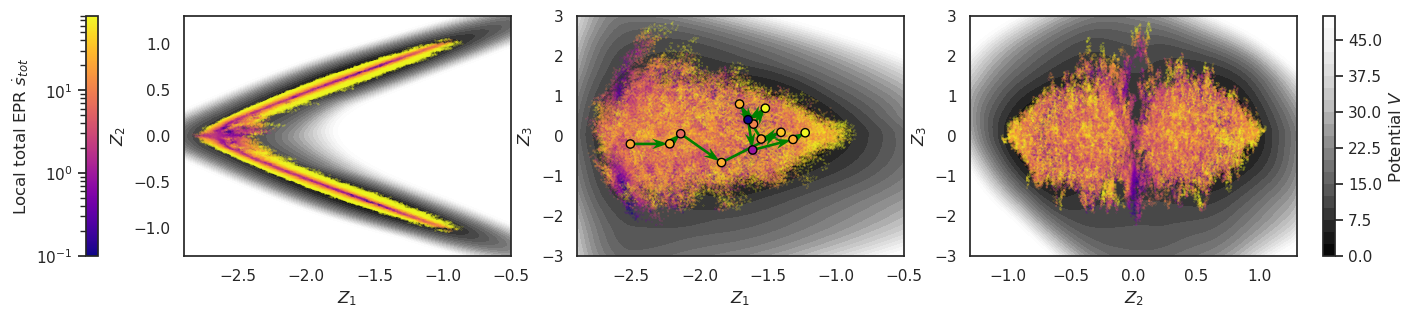

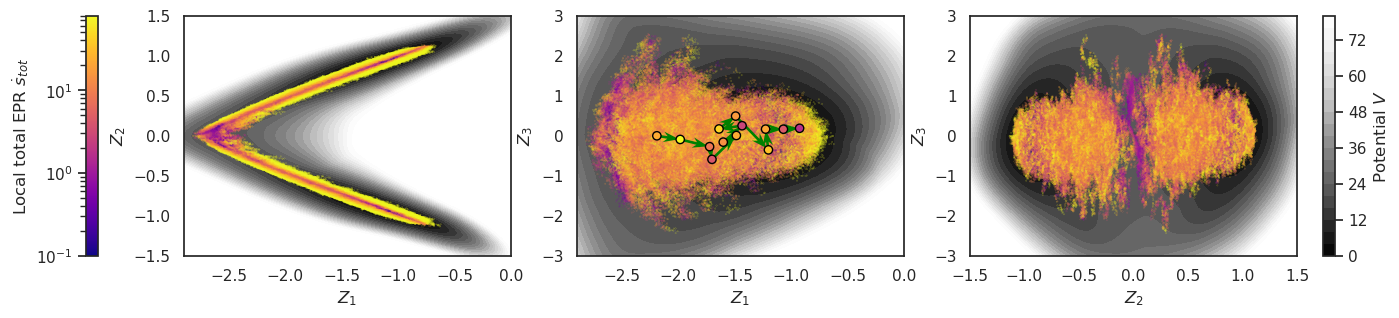

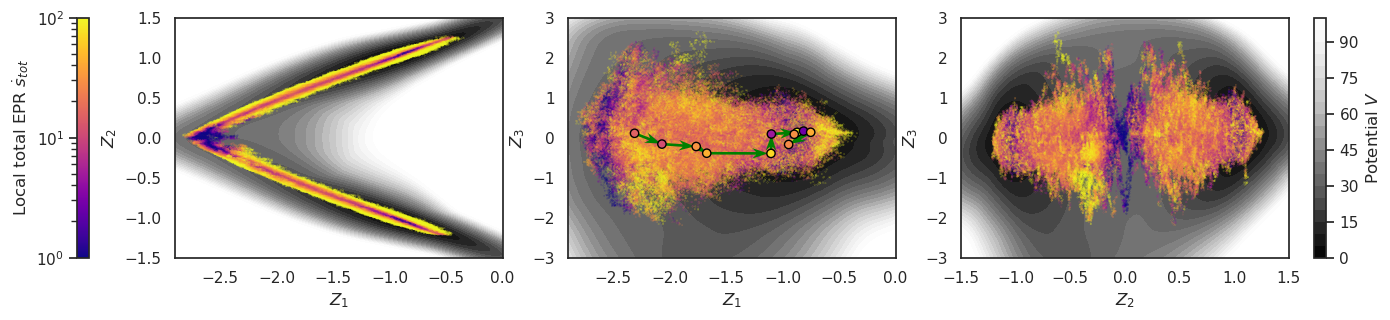

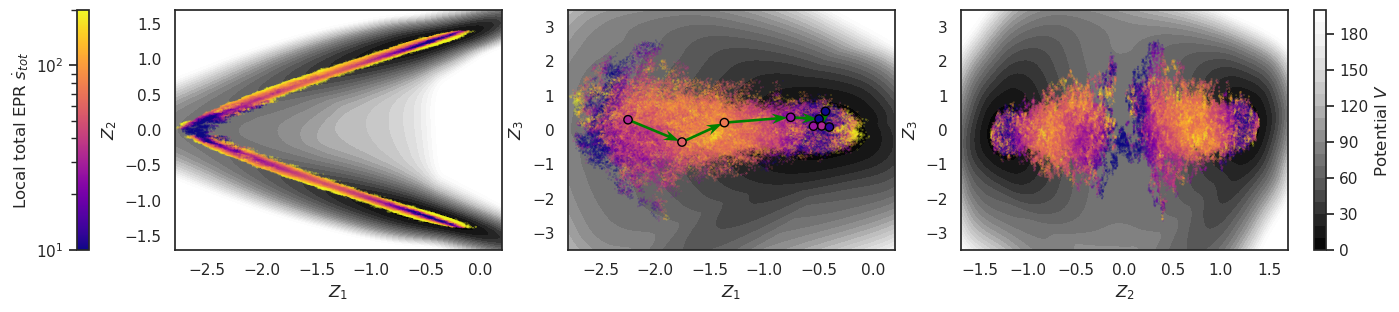

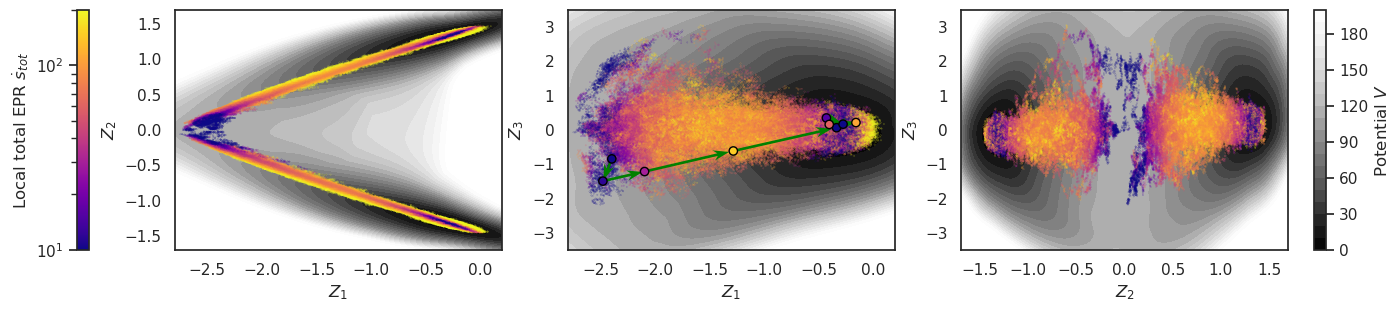

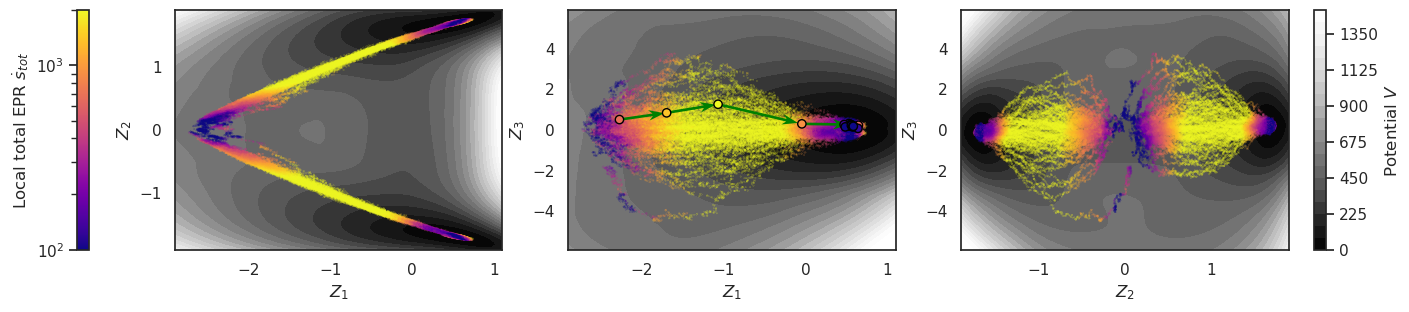

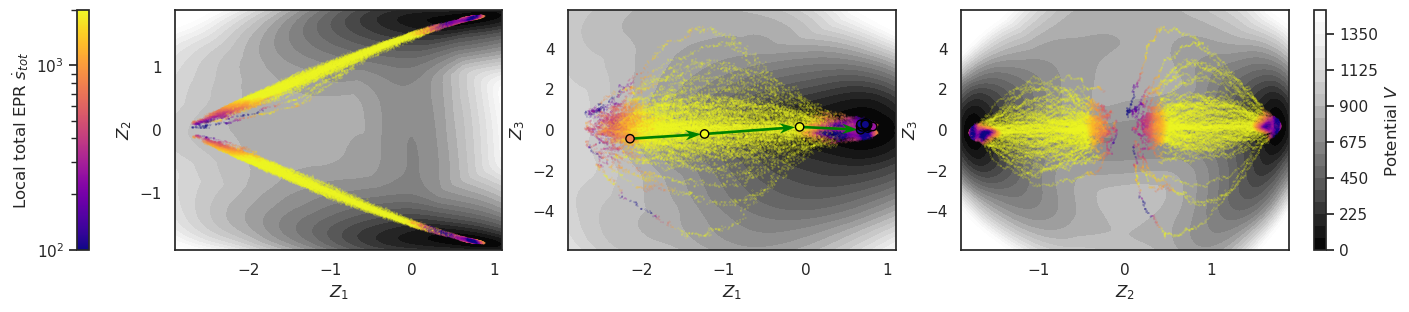

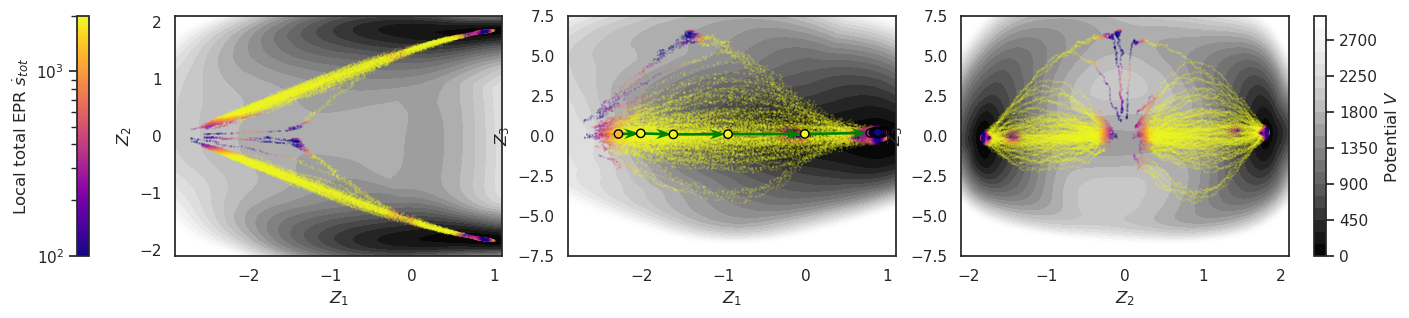

In [56]:
from omegaconf import OmegaConf
from utils_reduced_polymer import build_OnsagerNetHD2_scale
import equinox as eqx
seed = 0
data_set_key = "F3_93_T1" 


data_set_key_list=["F23_10_T1", "F16_20_T1", "F11_60_T1", 
                    "F4_63_T1", "F3_93_T1", "F2_78_T1", "F2_31_T1", "F1_62_T1"
                ]


def plot_ep(data_set_key = "F3_93_T1", ep_min=10, ep_max=200, level_end=200, num=1, steps=200, Z_domain=None):
    print(f"Processing dataset: {data_set_key}")
    dataset = loaded_dataset[data_set_key]
    x_train, x_test= train_test_split(dataset['x'], test_size=0.2, random_state=42)
    x_test_np_o = np.array(x_test)
    
    traj_len=x_test_np_o.shape[1]
    # print(x_test_np_o[:,0,0], traj_len)
    x_test_np=x_test_np_o.reshape(-1,3)

    V=[]
    for seed in [12]:
        path =  f"outputs/main{seed}_HD2"
        config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
        model_template = build_OnsagerNetHD2_scale(config) 
        net = eqx.tree_deserialise_leaves(os.path.join(path,data_set_key + '/model.eqx'), model_template) 
        ERP, fig, ax, V12, V13, V23 = PlotV(net, config, level_end=level_end, x_test_np=x_test_np, 
                                            ep_min=ep_min, ep_max=ep_max, traj_len=traj_len, num=num, steps=steps, Z_domain=Z_domain)
        # V.append((V12, V13, V23))

Z_domain= np.array([[-2.9,-0.5], [-1.3, 1.3], [-3,3]])
plot_ep(data_set_key = "F1_62_T1", ep_min=0.1, ep_max=80, level_end=50, num=1,Z_domain=Z_domain)

Z_domain= np.array([[-2.9,0], [-1.5, 1.5], [-3,3]])
plot_ep(data_set_key = "F2_31_T1", ep_min=0.1, ep_max=80, level_end=80, num=1,Z_domain=Z_domain)

Z_domain= np.array([[-2.9,0], [-1.5, 1.5], [-3,3]])
plot_ep(data_set_key = "F2_78_T1", ep_min=1, ep_max=100, level_end=100, num=1,Z_domain=Z_domain)

plot_ep(data_set_key = "F3_93_T1", ep_min=10, ep_max=200, level_end=200)
plot_ep(data_set_key = "F4_63_T1", ep_min=10, ep_max=200, level_end=200)

Z_domain= np.array([[-2.9,1.1], [-1.9, 1.9], [-5.9,5.9]])
plot_ep(data_set_key = "F11_60_T1", ep_min=100, ep_max=2000, level_end=1500, num=1, Z_domain=Z_domain, steps=50)

Z_domain= np.array([[-2.9,1.1], [-1.9, 1.9], [-5.9,5.9]])
plot_ep(data_set_key = "F16_20_T1", ep_min=100, ep_max=2000, level_end=1500, num=1, Z_domain=Z_domain, steps=50)

Z_domain= np.array([[-2.9,1.1], [-2.1, 2.1], [-7.5,7.5]])
plot_ep(data_set_key = "F23_10_T1", ep_min=100, ep_max=2000, level_end=3000, num=1, Z_domain=Z_domain, steps=20)

